En este notebook lo que vamos a realizar es clustering con los datos sobretodo para eliminar outlayers. Y tambien vamos a ver que variables son las mas importantes de las que nos hemos quedado.

In [40]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import json

In [41]:
pd.set_option('display.max_colwidth', None)

In [42]:
df = pd.read_csv("../data/working_data/idealista_data_cleaned_20250729.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5812 entries, 0 to 5811
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   price                          5812 non-null   int64  
 1   propertyType                   5812 non-null   object 
 2   operation                      5812 non-null   object 
 3   size                           5812 non-null   float64
 4   rooms                          5812 non-null   float64
 5   bathrooms                      5812 non-null   float64
 6   municipality                   5812 non-null   object 
 7   district                       5812 non-null   object 
 8   neighborhood                   5812 non-null   object 
 9   latitude                       5812 non-null   float64
 10  longitude                      5812 non-null   float64
 11  status                         5812 non-null   object 
 12  newDevelopment                 5812 non-null   b

Lo primero que vamos a hacer es pasar los datos a valores numéricos para poder hacerle el análisis de las componentes principales.

In [43]:
df["floor"].unique()

array([ 0. ,  8. ,  1. ,  3. ,  7. ,  2. ,  4. , 26. ,  6. ,  9. ,  5. ,
       10. , 17. , 16. , 20. , 14. , 13. , 23. ,  1.5, 24. , 11. , 28. ,
       12. , 19. , 27. , 15. , 25. , 22. ,  0.5, -1. , -2. , 18. , 50. ])

In [44]:
# Mapea valores textuales a enteros según significado
mapeo_floor = {
    "bj": 0,     # Bajo
    "en": 1.5,   # Entreplanta
    "ati": 50,  # Ático, lo voy a representar con 50 refiriendo a que siempre es lo mas alto.
    "st": -1,   # sotano
    "ss": 0.5     # sobre suelo
}

# # Aplica mapeo
# df["floor"] = df["floor"].replace(mapeo_floor)
# df["floor"] = df["floor"].fillna(0)

# # Convierte el resto a numérico (valores que eran strings de números)
# df["floor"] = pd.to_numeric(df["floor"], errors="coerce")

In [45]:
def categorical_to_numeric(df, manual_mappings=None):
    """
    Recorre TODAS las columnas del DataFrame:
    - Si ya es numérica, la deja.
    - Si es categórica o bool, la transforma.
    Guarda todos los mapeos (manuales + automáticos) en data/mapping_dict.json.
    
    :param df: DataFrame original
    :param manual_mappings: diccionario opcional de mapeos manuales
    :return: DataFrame transformado
    """
    mapping_dict = {}

    for column in df.columns:
        # Aplica mapeo manual si existe
        if manual_mappings and column in manual_mappings:
            df[column] = df[column].replace(manual_mappings[column])
            mapping_dict[column] = manual_mappings[column]
        
        # Si no tiene mapeo manual, transformamos si es categórica o bool
        elif df[column].dtype == "object":
            unique_values = df[column].unique()
            mapping = {str(value): int(i) for i, value in enumerate(unique_values)}
            df[column] = df[column].map(mapping)
            mapping_dict[column] = mapping
        
        elif df[column].dtype == "bool":
            df[column] = df[column].astype(int)
            mapping_dict[column] = {"True": 1, "False": 0}
        
        # Si es numérica, no hacemos nada

    # Guarda el diccionario
    with open("../data/mapping_dict.json", "w", encoding="utf-8") as f:
        json.dump(mapping_dict, f, ensure_ascii=False, indent=4)

    return df


In [46]:
df = categorical_to_numeric(df, manual_mappings={"floor": mapeo_floor})

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5812 entries, 0 to 5811
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   price                          5812 non-null   int64  
 1   propertyType                   5812 non-null   int64  
 2   operation                      5812 non-null   int64  
 3   size                           5812 non-null   float64
 4   rooms                          5812 non-null   float64
 5   bathrooms                      5812 non-null   float64
 6   municipality                   5812 non-null   int64  
 7   district                       5812 non-null   int64  
 8   neighborhood                   5812 non-null   int64  
 9   latitude                       5812 non-null   float64
 10  longitude                      5812 non-null   float64
 11  status                         5812 non-null   int64  
 12  newDevelopment                 5812 non-null   i

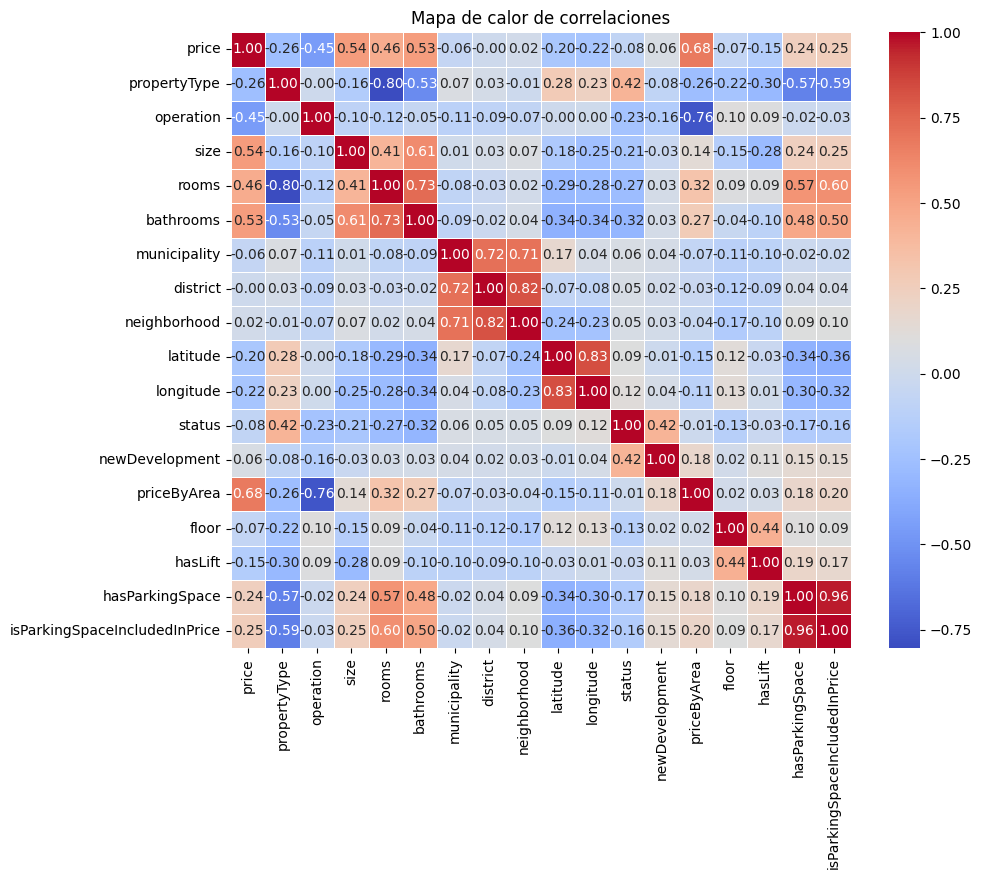

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar solo las columnas numéricas que te interesan
columnas = ['priceByArea', 'municipality', 'district', 'neighborhood', 'price', 'size'] 

# Crear matriz de correlación
corr = df.corr()

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Mapa de calor de correlaciones")
plt.show()


In [49]:
# guardamos dataframe sin columnas categoricas
df.to_csv("../data/working_data/idealista_data_cleaned_3.csv", index=False)

In [50]:
df[['operation', 'price']]

,operation,price
0,0,985000
1,0,265000
2,0,275000
3,0,1600000
4,0,550000
...,...,...
5807,0,9000
5808,0,22000
5809,0,8000
5810,0,9900


In [51]:
# Separamos alquiler y venta
df_rental = df[df["operation"]==1]
df_rental.to_csv("../data/working_data/idealista_data_rental_numeric.csv", index=False)
df_sales = df[df["operation"]==0]
df_sales.to_csv("../data/working_data/idealista_data_sales_numeric.csv", index=False)

In [52]:
df

,price,propertyType,operation,size,rooms,bathrooms,municipality,district,neighborhood,latitude,longitude,status,newDevelopment,priceByArea,floor,hasLift,hasParkingSpace,isParkingSpaceIncludedInPrice
0,985000,0,0,245.0,4.0,3.0,0,0,0,36.726046,-4.392859,0,0,4020.0,0.0,0.0,1,1
1,265000,1,0,66.0,2.0,1.0,0,1,1,36.703176,-4.438555,0,0,4015.0,8.0,1.0,0,0
2,275000,1,0,82.0,2.0,2.0,0,2,2,36.731530,-4.414621,0,0,3354.0,1.0,1.0,0,0
3,1600000,1,0,174.0,3.0,2.0,0,0,3,36.721393,-4.405125,0,0,9195.0,1.0,1.0,1,1
4,550000,1,0,143.0,3.0,2.0,0,2,4,36.720695,-4.421476,0,0,3846.0,3.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5807,9000,8,0,12.5,0.0,0.0,6,48,131,36.508218,-4.725346,3,0,300.0,-1.0,1.0,0,0
5808,22000,8,0,12.5,0.0,0.0,3,86,196,36.590990,-4.535055,3,0,815.0,0.0,0.0,0,0
5809,8000,8,0,12.5,0.0,0.0,14,2,203,36.631383,-4.502652,3,0,276.0,-1.0,0.0,0,0
5810,9900,8,0,12.5,0.0,0.0,3,34,105,36.581868,-4.551639,3,0,381.0,-1.0,1.0,0,0


Ya tenemos los datos numerico por lo que ya le podemos realizar el analisis de las componentes principales para ver cuantas variables son las que tienen mayor importancia para nuestro modelo

In [53]:
# Definimos las caractirísticas y el target que vamos a utilizar para el análisis de componentes principales
X = df
X = X.drop(columns="price")
Y = df["price"]

In [54]:
# vamos a escalar los datos primero
from sklearn.preprocessing import StandardScaler
standardized = StandardScaler()
standardized.fit(X)
scaled_data = standardized.transform(X)
X = scaled_data
X.shape

(5812, 17)

In [55]:
pca = PCA(n_components = 17)                          # Define a PCA object.
pca.fit(X)   

PCA(n_components=17)

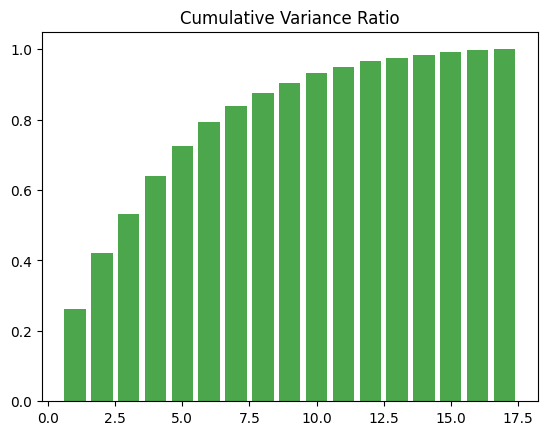

In [56]:
# Visualize the CVRs as a Barplot.
CVRs = np.cumsum(pca.explained_variance_ratio_)        # Calculate the CVRs.
nPCs = np.arange(17)+1                                 # Define an array that corresponds to the number of PCs.
plt.bar(nPCs,CVRs,color = 'green', alpha=0.7)  
plt.title('Cumulative Variance Ratio')
plt.show()

Con unas 15 o 16 variables seria suficiente, lo que tiene sentido, porque no creo que aporten demasiado a lo que es el modelo las características: province, municipality, district, country o neighborhood

Quiero usar dbscan para detectar los outliers, voy a hacer dos pruebas, 
La primera voy a usar solo price y propertytipe para ver como se comportan los datos graficamente y si hay precios que se salen mucho de la media por el tipo de vivienda
En la segunda voy a añadir bastantes columnas y voy a ponerlo creo que solo en forma de codigo, con el codigo de abajo, obviamente no voy a poner en esas columnas las de los barrios creo, voy a poner mas bien las otras

In [57]:
X_1 = df[["price", "propertyType"]]

standardized.fit(X_1)
scaled_data = standardized.transform(X_1)
X_1 = scaled_data

dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X_1)

df["dbscan1_labels"] = labels

df_outliers = df[df['dbscan1_labels'] == -1]
print(f"Outliers detectados: {len(df_outliers)}")


Outliers detectados: 13


In [58]:
df["dbscan1_labels"].value_counts()

dbscan1_labels
 0    5799
-1      13
Name: count, dtype: int64

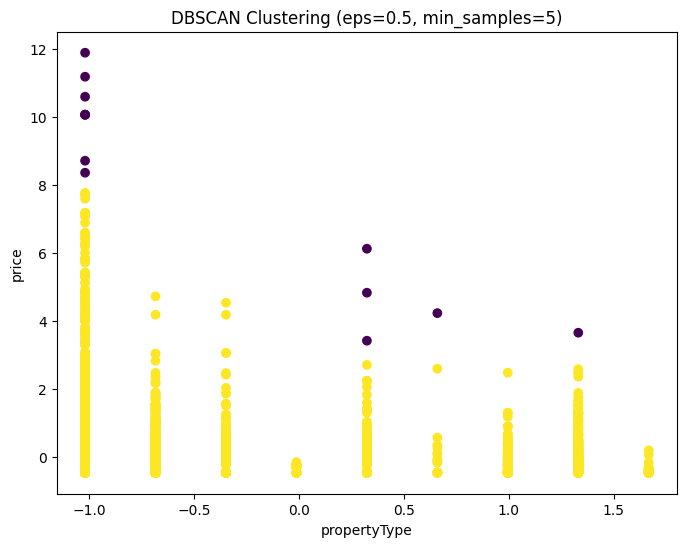

In [59]:
# Plot the clusters
plt.figure(figsize=(8,6))
plt.scatter(X_1[:, 1], X_1[:, 0], c=labels)
plt.xlabel('propertyType')
plt.ylabel('price')
plt.title(f'DBSCAN Clustering (eps={dbscan.eps}, min_samples={dbscan.min_samples})')
plt.show()

In [60]:
X_2 = df.drop(columns=[ "municipality", "district", "neighborhood"])

standardized.fit(X_2)
scaled_data = standardized.transform(X_2)
X_2 = scaled_data

dbscan = DBSCAN(eps=1, min_samples=8)
labels = dbscan.fit_predict(X_2)

# Agrega etiquetas al DF original
df['dbscan2_label'] = labels

df_outliers = df[df['dbscan2_label'] == -1]

print(f"Outliers detectados: {len(df_outliers)}")


Outliers detectados: 1112


No puedo quitarme tantiiisimos datos, no se como mirar de mejor forma los outliers o si dejarlo todo y ya esta, pero algo de valor le tengo que sacar a hacer la limpieza la verdad.

#### Eliminando valores extremos 

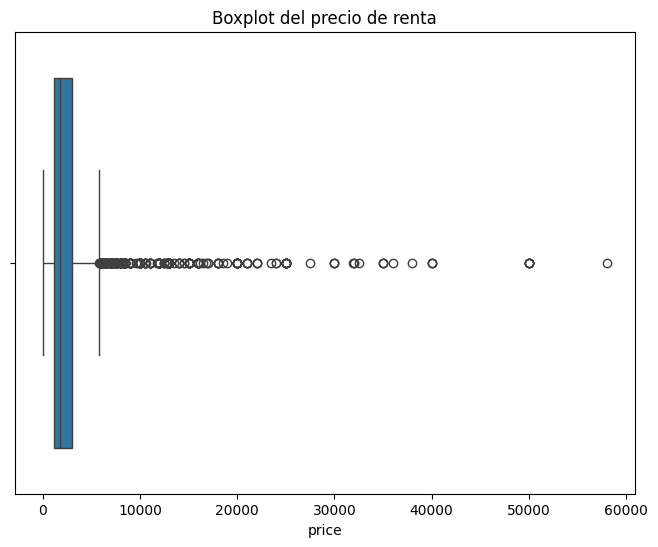

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aumenta el tamaño de la figura para que se vea mejor
plt.figure(figsize=(8, 6))

# Dibuja el boxplot de la columna 'price'
sns.boxplot(x=df_rental["price"])

# Añade título
plt.title("Boxplot del precio de renta")

# Muestra la gráfica
plt.show()


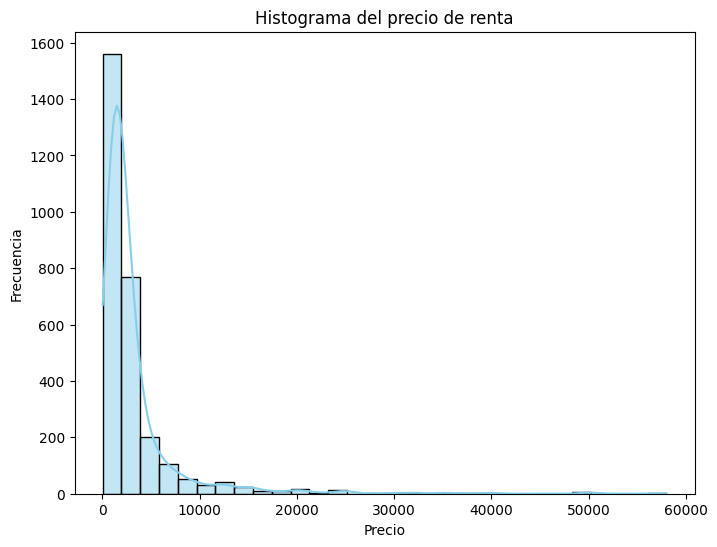

In [62]:
plt.figure(figsize=(8, 6))

sns.histplot(df_rental["price"], bins=30, kde=True, color='skyblue')  # kde=True añade la curva de densidad

plt.title("Histograma del precio de renta")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")

plt.show()


Vamos a realizar el metodo del rango intercuartilico para quitar los valores extremos

In [63]:
# Calcular percentiles
Q1 = df_rental["price"].quantile(0.25)
Q3 = df_rental["price"].quantile(0.75)

# Calcular rango intercuartílico
IQR = Q3 - Q1

# Definir límites inferior y superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Límite inferior: {limite_inferior}")
print(f"Límite superior: {limite_superior}")

# Filtrar el DataFrame para quedarnos solo con los valores dentro de los límites
df_rental_filtrado = df_rental[(df_rental["price"] >= limite_inferior) & (df_rental["price"] <= limite_superior)]

print(f"Número de registros antes de filtrar: {len(df_rental)}")
print(f"Número de registros después de filtrar: {len(df_rental_filtrado)}")


Q1: 1150.0
Q3: 3000.0
IQR: 1850.0
Límite inferior: -1625.0
Límite superior: 5775.0
Número de registros antes de filtrar: 2859
Número de registros después de filtrar: 2530


Volvemos a ver, las graficas para ver como ha cambiado la distribucion de los datos

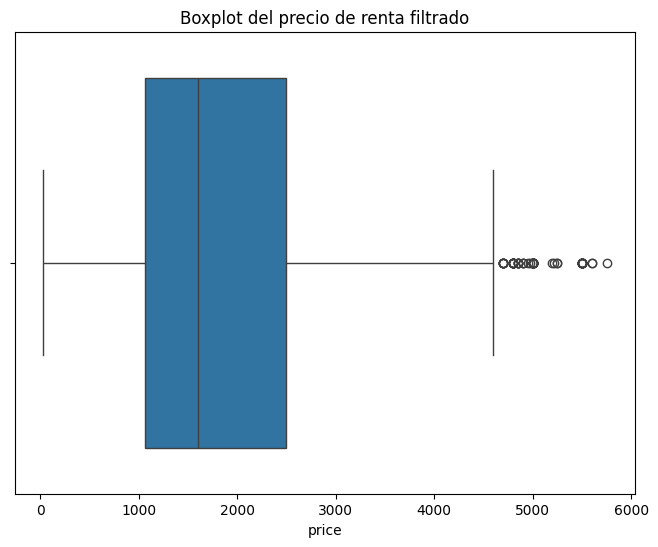

In [64]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_rental_filtrado["price"])
plt.title("Boxplot del precio de renta filtrado")
plt.show()

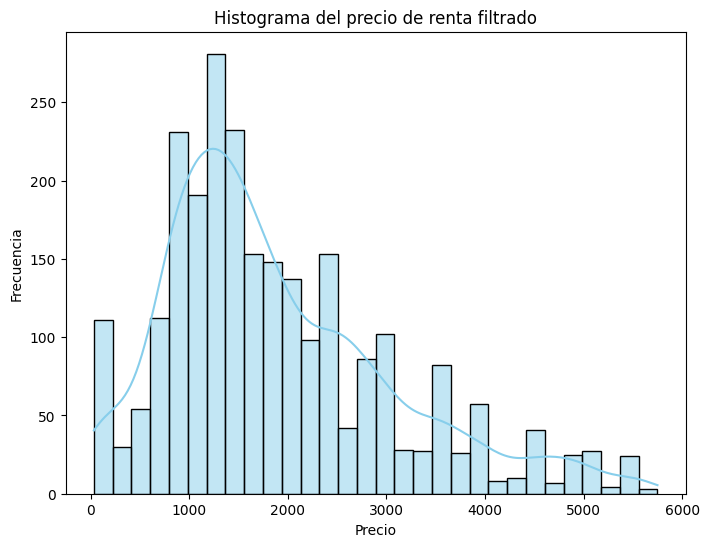

In [65]:
plt.figure(figsize=(8, 6))

sns.histplot(df_rental_filtrado["price"], bins=30, kde=True, color='skyblue')  # kde=True añade la curva de densidad
plt.title("Histograma del precio de renta filtrado")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")

plt.show()

In [66]:
# Guardamos los datos filtrados
df_rental_filtrado.to_csv("../data/working_data/idealista_data_rental_numeric_filtered.csv", index=False)

Vamos a hacer lo mismo pero ahora para los valores de venta

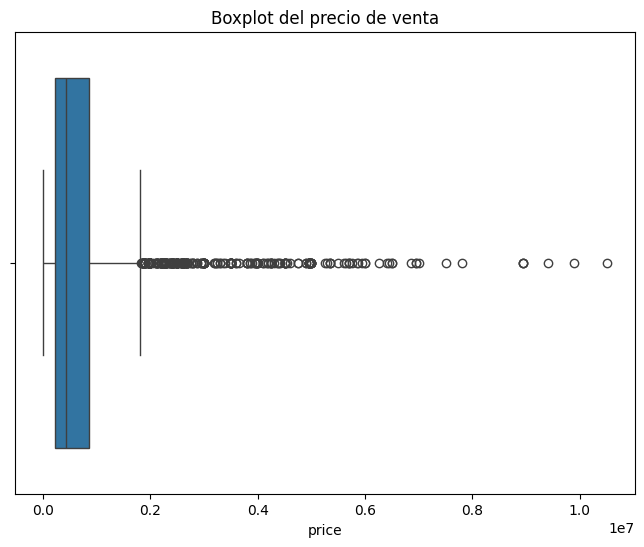

In [67]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_sales["price"])
plt.title("Boxplot del precio de venta")
plt.show()


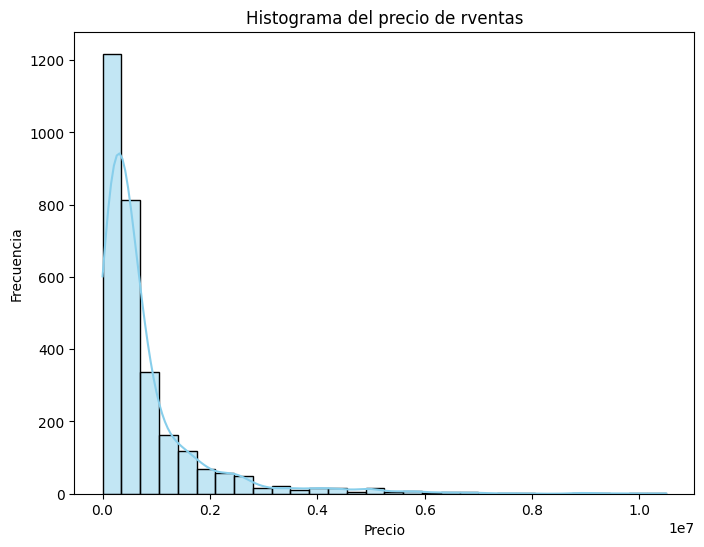

In [68]:
plt.figure(figsize=(8, 6))

sns.histplot(df_sales["price"], bins=30, kde=True, color='skyblue')  # kde=True añade la curva de densidad
plt.title("Histograma del precio de rventas")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")

plt.show()

In [69]:
# Calcular percentiles
Q1 = df_sales["price"].quantile(0.25)
Q3 = df_sales["price"].quantile(0.75)

# Calcular rango intercuartílico
IQR = Q3 - Q1

# Definir límites inferior y superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Límite inferior: {limite_inferior}")
print(f"Límite superior: {limite_superior}")

# Filtrar el DataFrame para quedarnos solo con los valores dentro de los límites
df_sales_filtrado = df_sales[(df_sales["price"] >= limite_inferior) & (df_sales["price"] <= limite_superior)]

print(f"Número de registros antes de filtrar: {len(df_sales)}")
print(f"Número de registros después de filtrar: {len(df_sales_filtrado)}")

Q1: 215100.0
Q3: 850000.0
IQR: 634900.0
Límite inferior: -737250.0
Límite superior: 1802350.0
Número de registros antes de filtrar: 2953
Número de registros después de filtrar: 2659


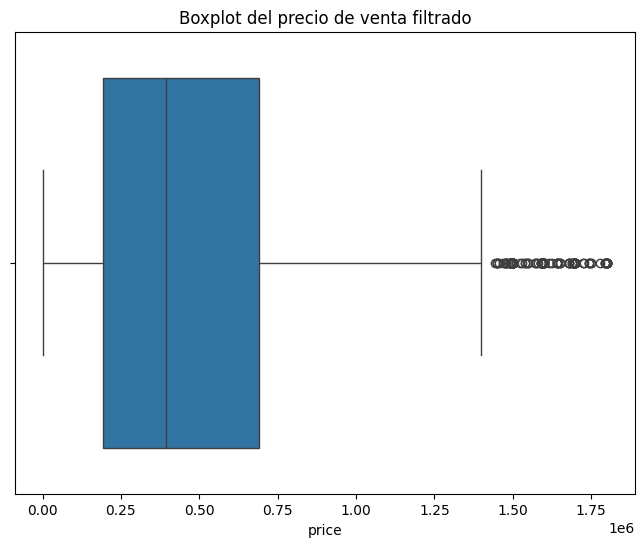

In [70]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_sales_filtrado["price"])
plt.title("Boxplot del precio de venta filtrado")
plt.show()

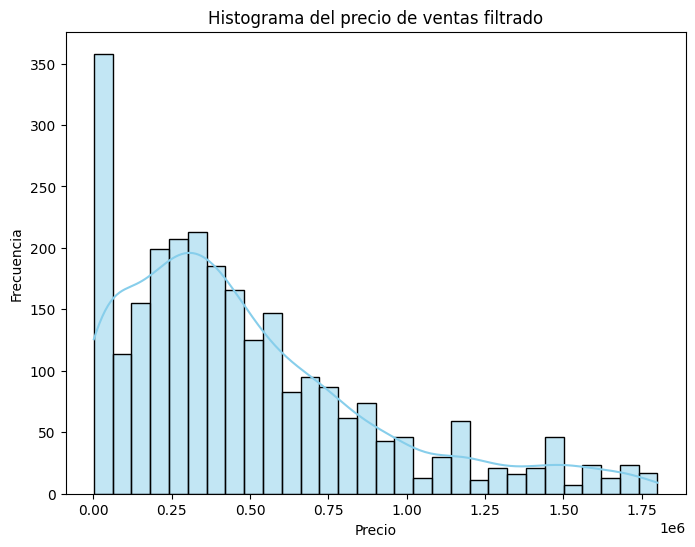

In [71]:
plt.figure(figsize=(8, 6))

sns.histplot(df_sales_filtrado["price"], bins=30, kde=True, color='skyblue')  # kde=True añade la curva de densidad
plt.title("Histograma del precio de ventas filtrado")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")

plt.show()

In [72]:
# Guardamos el dataframe filtrado
df_sales_filtrado.to_csv("../data/working_data/idealista_data_sales_numeric_filtered.csv", index=False)

Filtramos tambien los categoricos

In [73]:
df_rental_categoric = pd.read_csv("../data/working_data/idealista_data_rental_categorical.csv")
# Calcular percentiles
Q1 = df_rental_categoric["price"].quantile(0.25)
Q3 = df_rental_categoric["price"].quantile(0.75)

# Calcular rango intercuartílico
IQR = Q3 - Q1

# Definir límites inferior y superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Límite inferior: {limite_inferior}")
print(f"Límite superior: {limite_superior}")

# Filtrar el DataFrame para quedarnos solo con los valores dentro de los límites
df_rental_categoric_filtrado = df_rental_categoric[(df_rental_categoric["price"] >= limite_inferior) & (df_rental_categoric["price"] <= limite_superior)]

print(f"Número de registros antes de filtrar: {len(df_rental_categoric)}")
print(f"Número de registros después de filtrar: {len(df_rental_categoric_filtrado)}")

df_rental_categoric_filtrado.to_csv("../data/working_data/idealista_data_rental_categorical_filtered.csv", index=False)


Q1: 1150.0
Q3: 3000.0
IQR: 1850.0
Límite inferior: -1625.0
Límite superior: 5775.0
Número de registros antes de filtrar: 2859
Número de registros después de filtrar: 2530


In [74]:
df_sales_categoric = pd.read_csv("../data/working_data/idealista_data_sales_categorical.csv")
# Calcular percentiles
Q1 = df_sales_categoric["price"].quantile(0.25)
Q3 = df_sales_categoric["price"].quantile(0.75)

# Calcular rango intercuartílico
IQR = Q3 - Q1

# Definir límites inferior y superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Límite inferior: {limite_inferior}")
print(f"Límite superior: {limite_superior}")

# Filtrar el DataFrame para quedarnos solo con los valores dentro de los límites
df_sales_categoric_filtrado = df_sales_categoric[(df_sales_categoric["price"] >= limite_inferior) & (df_sales_categoric["price"] <= limite_superior)]

print(f"Número de registros antes de filtrar: {len(df_sales_categoric)}")
print(f"Número de registros después de filtrar: {len(df_sales_categoric_filtrado)}")

df_sales_categoric_filtrado.to_csv("../data/working_data/idealista_data_sales_categorical_filtered.csv", index=False)

Q1: 215100.0
Q3: 850000.0
IQR: 634900.0
Límite inferior: -737250.0
Límite superior: 1802350.0
Número de registros antes de filtrar: 2953
Número de registros después de filtrar: 2659
